# PART 1. Data Pre-processing
## Step #0. Fire the system

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
plt.style.use('bmh')
import datetime as dt
from datetime import datetime
# from google.colab import drive 
# drive.mount('/content/drive')

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

## Step #1. Read data

In [2]:
# Importing Training Set
df = pd.read_csv('C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\HUDaily.csv', index_col=0, parse_dates=True)

array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

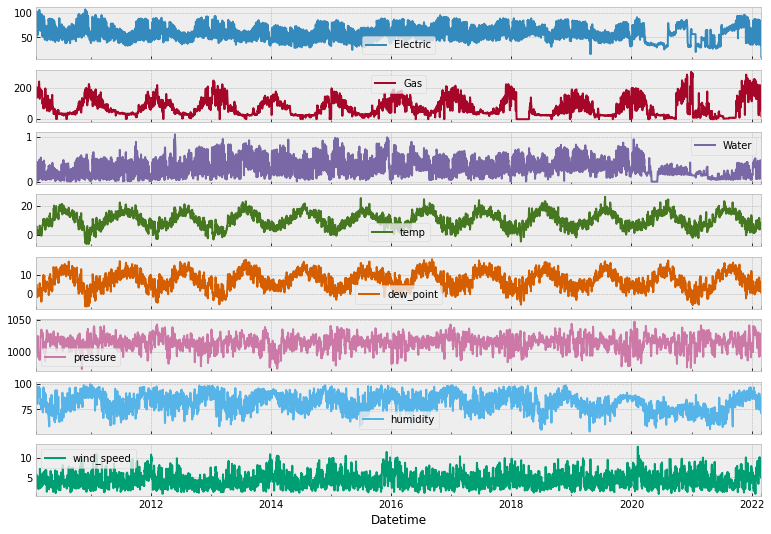

In [3]:
df.plot(subplots=True, figsize=(13,9))

In [4]:
df = df.loc[:'2020-03-24']
data = df.reset_index()

dataset_train = data.copy()

dataset_train

,Datetime,Electric,Gas,Water,temp,dew_point,pressure,humidity,wind_speed
0,2010-02-02,101.613979,139.386646,0.102313,4.377917,3.256250,1005.291667,92.458333,5.823750
1,2010-02-03,98.845000,182.338125,0.375250,1.380000,0.423750,1007.625000,93.333333,2.943750
2,2010-02-04,97.897604,152.264583,0.428312,5.105833,4.458333,1004.333333,95.666667,4.350000
3,2010-02-05,87.718333,134.719208,0.377042,6.210417,5.026250,999.625000,92.333333,3.540417
4,2010-02-06,55.565125,135.339687,0.089542,3.039167,2.714167,1015.208333,97.750000,3.332917
...,...,...,...,...,...,...,...,...,...
3706,2020-03-27,38.312500,109.646833,0.185562,5.276250,0.992500,1026.541667,75.166667,4.991250
3707,2020-03-28,39.250000,112.318229,0.180667,5.784583,1.972500,1032.041667,77.000000,7.568333
3708,2020-03-29,39.125000,121.842667,0.192000,4.198750,-1.072083,1040.583333,68.416667,7.811250
3709,2020-03-30,40.416667,119.519583,0.193146,4.872917,1.881667,1036.208333,80.750000,5.350833


In [5]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:9]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Datetime'])
# datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (3711, 9)
All timestamps == 3711
Featured selected: ['Electric', 'Gas', 'Water', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed']


## Step #2. Data pre-processing
Removing all commas and convert data to matrix shape format.

In [6]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set[:1]

Shape of training set == (3711, 8).


array([[1.01613979e+02, 1.39386646e+02, 1.02312500e-01, 4.37791667e+00,
        3.25625000e+00, 1.00529167e+03, 9.24583333e+01, 5.82375000e+00]])

In [7]:
# Feature Scaling
from sklearn.preprocessing import *

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.94215748],
       [0.91165596],
       [0.90121998],
       ...,
       [0.25381404],
       [0.26804231],
       [0.24073321]])

In [8]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 730  # Number of days we want top predict into the future
n_past = 1     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2981, 1, 7).
y_train shape == (2981, 1).


# PART 2. Create a model. Training
## Step #3. Building the LSTM based Neural Network

In [9]:
# Import Libraries and packages from Keras
from keras.models import *
from keras.layers import *

In [50]:
# # Initializing the Neural Network based on LSTM
# model = Sequential()

# # Adding 1st LSTM layer
# model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# # Adding 2nd LSTM layer
# model.add(LSTM(units=128, activation='relu', return_sequences=True))

# # model.add(Dropout(0.2))

# model.add(LSTM(units=128, activation='relu', return_sequences=True))

# # model.add(Dropout(0.2))

# model.add(LSTM(units=128, activation='relu', return_sequences=True))

# # model.add(Dropout(0.2))

# model.add(LSTM(units=128, activation='relu', return_sequences=False))

# # Adding Dropout
# model.add(Dropout(0.2))

# # Output layer
# # model.add(Dense(units=64, activation='relu'))

# model.add(Dense(units=1))

model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(n_past, dataset_train.shape[1]-1), return_sequences=True))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu'))
model.add(Dropout(rate=0.25))
# model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1))
# model.summary()

# model = Sequential()
# model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
# model.add(Bidirectional(LSTM(units=128)))
# model.add(Dropout(rate=0.25))
# model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer='adam', loss='mean_squared_error')

## Step #4. Start training

In [51]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.1, verbose=1)

Epoch 1/100
83/84 [============================>.] - ETA: 0s - loss: 0.2391
Epoch 1: val_loss improved from inf to 0.10509, saving model to weights.h5
84/84 [==============================] - 13s 18ms/step - loss: 0.2375 - val_loss: 0.1051 - lr: 0.0010
Epoch 2/100
80/84 [===========================>..] - ETA: 0s - loss: 0.0483
Epoch 2: val_loss improved from 0.10509 to 0.02625, saving model to weights.h5
84/84 [==============================] - 1s 7ms/step - loss: 0.0477 - val_loss: 0.0263 - lr: 0.0010
Epoch 3/100
80/84 [===========================>..] - ETA: 0s - loss: 0.0353
Epoch 3: val_loss improved from 0.02625 to 0.02553, saving model to weights.h5
84/84 [==============================] - 1s 7ms/step - loss: 0.0352 - val_loss: 0.0255 - lr: 0.0010
Epoch 4/100
76/84 [==========================>...] - ETA: 0s - loss: 0.0342
Epoch 4: val_loss did not improve from 0.02553
84/84 [==============================] - 1s 7ms/step - loss: 0.0343 - val_loss: 0.0265 - lr: 0.0010
Epoch 5/100
80

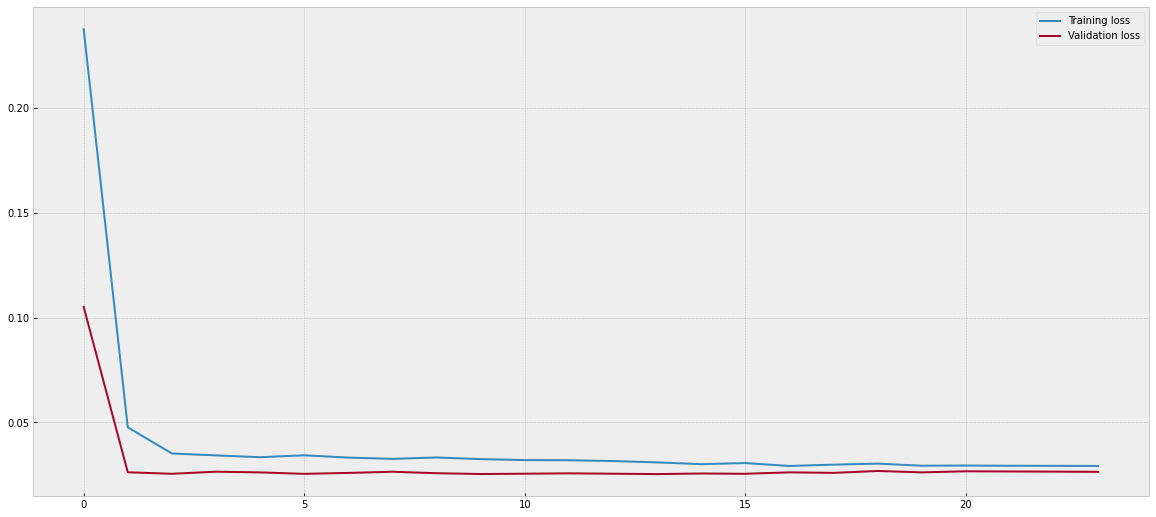

In [52]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

## PART 3. Make future predictions

In [53]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

## Step #5. Make predictions for future dates

In [54]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

predictions_train1 = model.predict(X_train)

## Step #6. Evaluate Metrics

In [55]:
from sklearn.metrics import *

print('RMSE: ', np.sqrt(mean_squared_error(y_train, predictions_train1)))
print('MSE: ', mean_squared_error(y_train, predictions_train1))
print('MAE: ', mean_absolute_error(y_train, predictions_train1))
print('R2: ', r2_score(y_train, predictions_train1))

RMSE:  0.1614780610219179
MSE:  0.02607516419139824
MAE:  0.13395711316925732
R2:  0.03196052960268059


In [56]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['value']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['value']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,value
2012-02-03,71.123131
2012-02-04,70.160484
2012-02-05,68.781357


In [57]:
datelist_train = pd.to_datetime(datelist_train)

In [58]:
dataset_train = dataset_train.set_index(datelist_train)

In [59]:
dataset_train.head()

,Electric,Gas,Water,temp,dew_point,pressure,humidity,wind_speed
2010-02-02,101.613979,139.386646,0.102313,4.377917,3.256250,1005.291667,92.458333,5.823750
2010-02-03,98.845000,182.338125,0.375250,1.380000,0.423750,1007.625000,93.333333,2.943750
2010-02-04,97.897604,152.264583,0.428312,5.105833,4.458333,1004.333333,95.666667,4.350000
2010-02-05,87.718333,134.719208,0.377042,6.210417,5.026250,999.625000,92.333333,3.540417
2010-02-06,55.565125,135.339687,0.089542,3.039167,2.714167,1015.208333,97.750000,3.332917


## Step #6. Visualize the Predictions

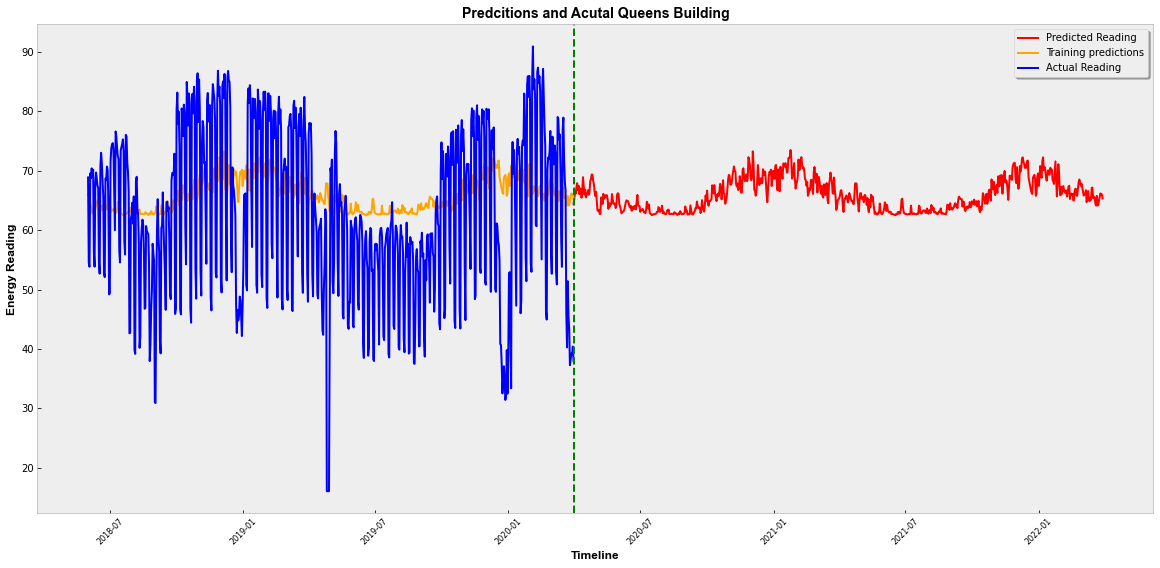

In [60]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 9

# Plot parameters
START_DATE_FOR_PLOTTING = '2018-06'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['value'], color='r', label='Predicted Reading')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['value'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Electric'], color='b', label='Actual Reading')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Queens Building', family='Arial', fontsize=14, fontweight='bold')
plt.xlabel('Timeline', family='Arial', fontsize=12, fontweight='bold')
plt.ylabel('Energy Reading', family='Arial', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, fontsize=8)
plt.show()